<a href="https://colab.research.google.com/github/eridanletalis/GB_nn/blob/main/hw6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка библиотек

In [1]:
!git clone https://github.com/bearpaw/clothing-co-parsing.git

Cloning into 'clothing-co-parsing'...
remote: Enumerating objects: 4234, done.
remote: Total 4234 (delta 0), reused 0 (delta 0), pack-reused 4234
Receiving objects: 100% (4234/4234), 124.59 MiB | 45.32 MiB/s, done.
Resolving deltas: 100% (1100/1100), done.


In [2]:
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array

import matplotlib.pyplot as plt
import os
from scipy import io
from sklearn.model_selection import train_test_split

# Проверить устройства для кераса

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6597019026072777717
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14444920832
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7482247248007902331
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


# Функции для визуализации

In [4]:
def display(display_list):
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  plt.figure(figsize=(15, 15))
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def show_predictions(model, dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

# Загрузка датасета и обработка

In [5]:
DATASET_PATH = '/content/clothing-co-parsing/photos/'
MASKS_PATH = '/content/clothing-co-parsing/annotations/pixel-level/'

In [6]:
def preprocess_image(image):
     image = tf.cast(image, tf.float32)
     # scale values to [0,1]
     image = image/255.0
     # resize image
     image = tf.image.resize(image, (128,128))
     return image 
     

def preprocess_mask(mask):
    mask = tf.expand_dims(mask, axis=-1)
    mask = tf.image.resize(mask, (128,128))
    # будем использовать бинарную классификацию - фон и человек
    # для этого фон, закодированный нулем, оставим нулевым
    # все остальное будет равно единице
    mask = tf.cast(mask != 0, tf.uint8)
    return mask  

In [7]:
images = []
masks = []

for mask_filename in os.listdir(MASKS_PATH):
  image_filename = mask_filename[:-4] + '.jpg'
  image = img_to_array(load_img(DATASET_PATH + image_filename))
  images.append(preprocess_image(image))
      
  mask_file = io.loadmat(MASKS_PATH + mask_filename)
  mask = tf.convert_to_tensor(mask_file['groundtruth']) 
  masks.append(preprocess_mask(mask))

In [8]:
train_X, test_X, train_Y, test_Y = train_test_split(images, masks,\
                                                 test_size=0.2, random_state=0)
sample_image, sample_mask = train_X[0], train_Y[0]

train_X = tf.data.Dataset.from_tensor_slices(train_X)
test_X = tf.data.Dataset.from_tensor_slices(test_X)
train_Y = tf.data.Dataset.from_tensor_slices(train_Y)
test_Y = tf.data.Dataset.from_tensor_slices(test_Y)

train = tf.data.Dataset.zip((train_X, train_Y))
test = tf.data.Dataset.zip((test_X, test_Y)) 

In [9]:
# функции для аугментации 

# яркость
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    return img, mask

# оттенок
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    return img, mask

# отзеркаливание по горизонтали
def flip_horisontal(img, mask):
     img = tf.image.flip_left_right(img)
     mask = tf.image.flip_left_right(mask)
     return img, mask

In [10]:
# последовательно применяем аугментации
train = train.concatenate(train.map(brightness))
train = train.concatenate(train.map(hue))
train = train.concatenate(train.map(flip_horisontal))

In [11]:
len(train)

6424

In [12]:
BATCH_SIZE = 32
BUFFER_SIZE = 500
train = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train = train.prefetch(buffer_size=BUFFER_SIZE)
test = test.batch(BATCH_SIZE) 

In [13]:
tf.random.set_seed(0)

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [16]:
up_stack = [
    tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu'),
    tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same', 
                                    use_bias=False, activation='relu')
]

In [17]:
def resolution_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(output_channels, 3, strides=2, 
                                         padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [18]:
OUTPUT_CHANNELS = 3

model = resolution_model(OUTPUT_CHANNELS)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

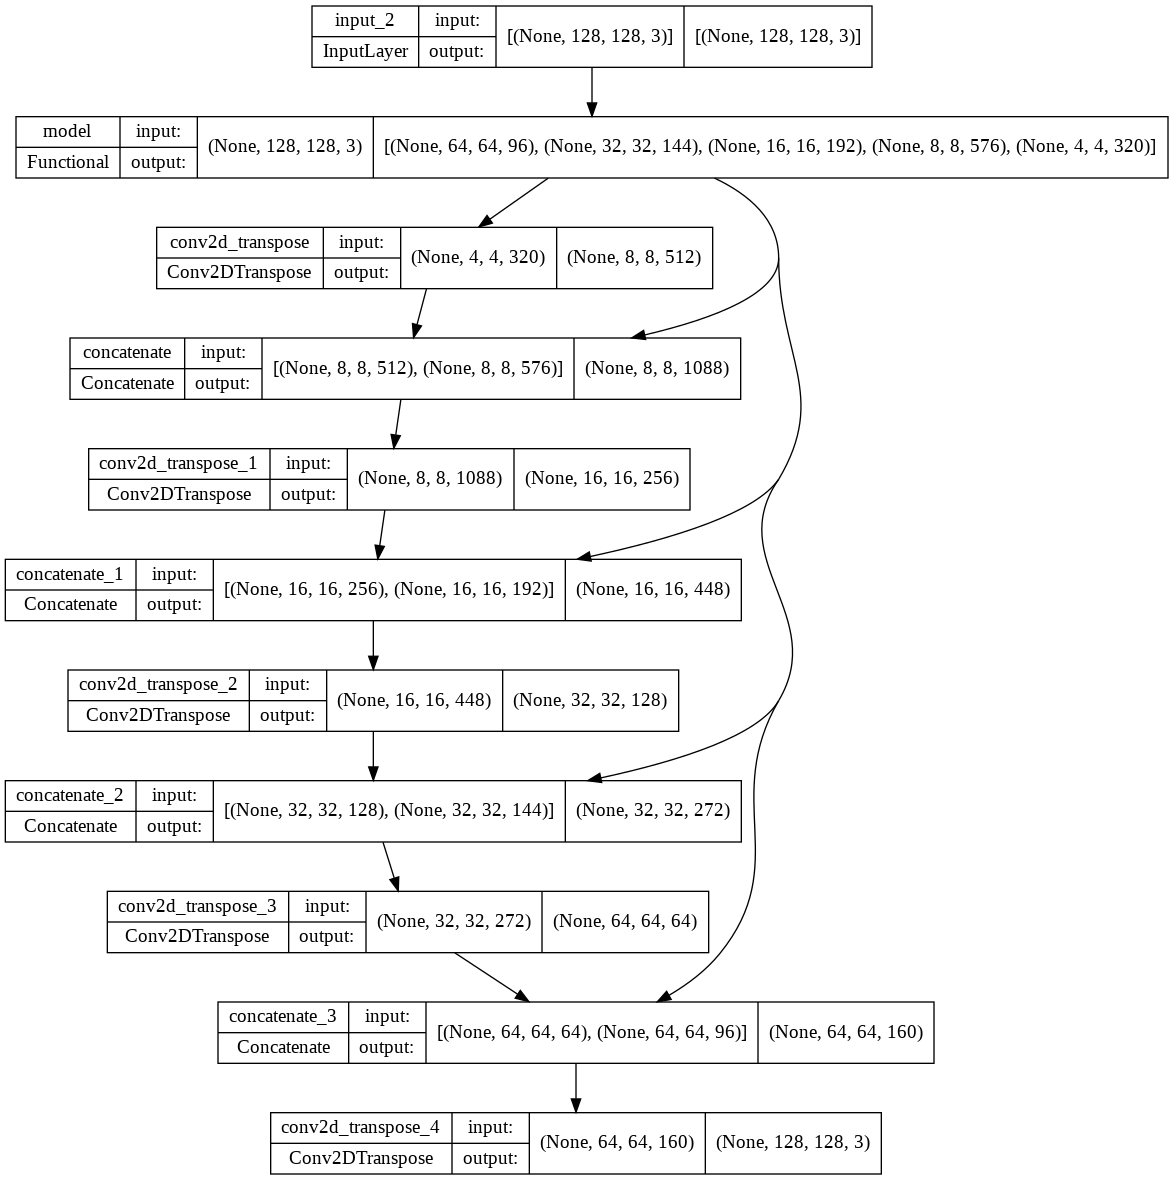

In [19]:
tf.keras.utils.plot_model(model, show_shapes=True)

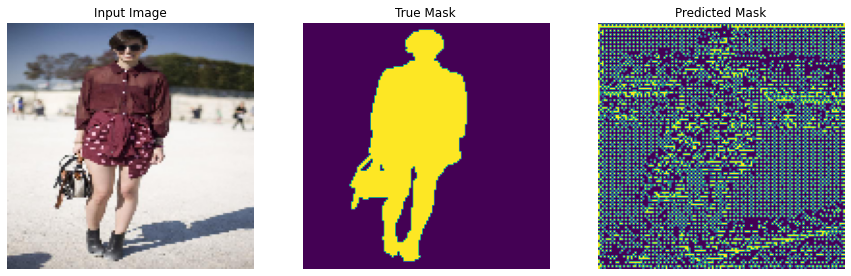

In [20]:
show_predictions(model)

Epoch 1/20
201/201 [==============================] - ETA: 0s - loss: 0.1642 - accuracy: 0.9336

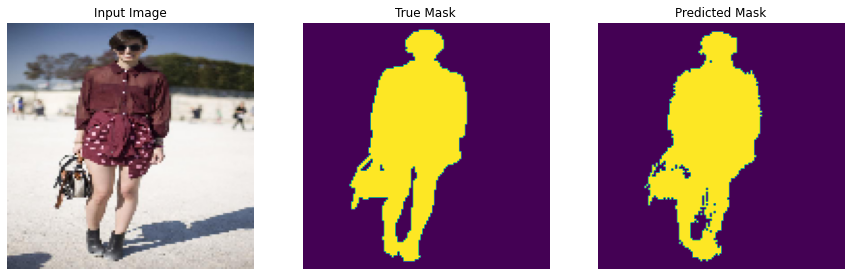


Sample Prediction after epoch 1

201/201 [==============================] - 20s 75ms/step - loss: 0.1642 - accuracy: 0.9336 - val_loss: 0.0939 - val_accuracy: 0.9625
Epoch 2/20
201/201 [==============================] - ETA: 0s - loss: 0.0791 - accuracy: 0.9689

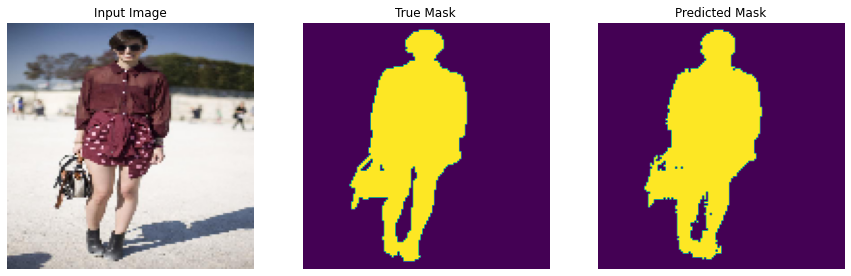


Sample Prediction after epoch 2

201/201 [==============================] - 13s 63ms/step - loss: 0.0791 - accuracy: 0.9689 - val_loss: 0.0747 - val_accuracy: 0.9706
Epoch 3/20
201/201 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9757

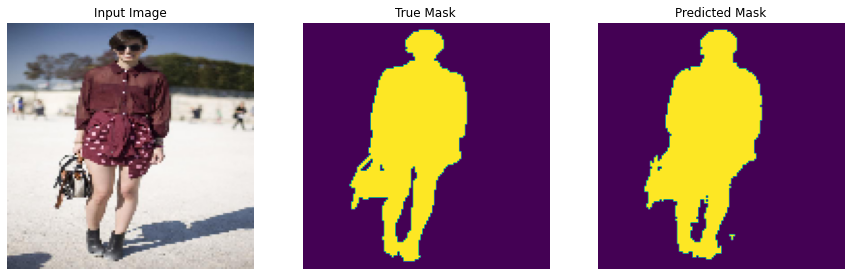


Sample Prediction after epoch 3

201/201 [==============================] - 12s 62ms/step - loss: 0.0624 - accuracy: 0.9757 - val_loss: 0.0705 - val_accuracy: 0.9727
Epoch 4/20
201/201 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9800

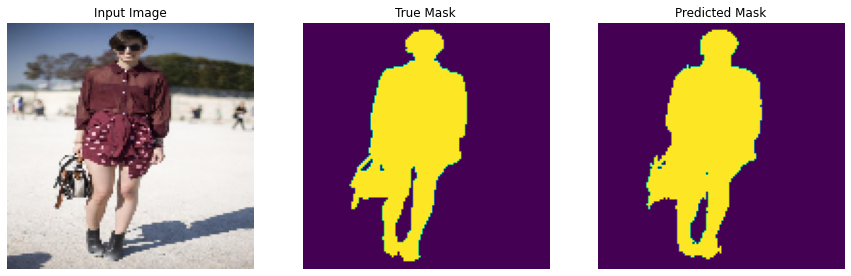


Sample Prediction after epoch 4

201/201 [==============================] - 12s 62ms/step - loss: 0.0513 - accuracy: 0.9800 - val_loss: 0.0700 - val_accuracy: 0.9733
Epoch 5/20
201/201 [==============================] - ETA: 0s - loss: 0.0439 - accuracy: 0.9828

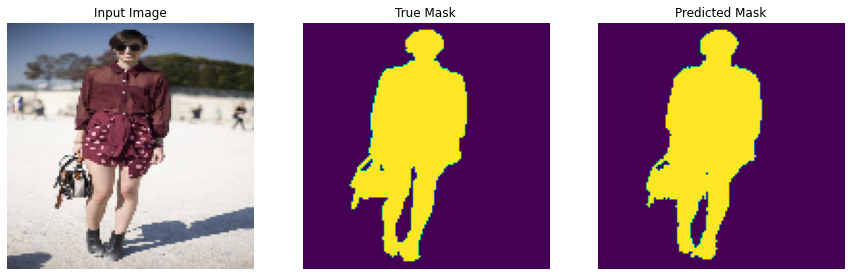


Sample Prediction after epoch 5

201/201 [==============================] - 13s 62ms/step - loss: 0.0439 - accuracy: 0.9828 - val_loss: 0.0683 - val_accuracy: 0.9746
Epoch 6/20
201/201 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9853

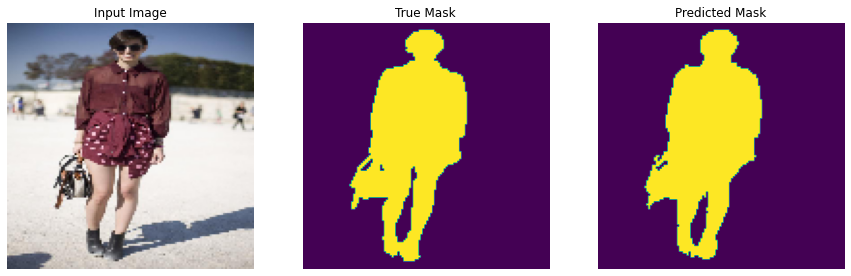


Sample Prediction after epoch 6

201/201 [==============================] - 14s 67ms/step - loss: 0.0372 - accuracy: 0.9853 - val_loss: 0.0721 - val_accuracy: 0.9743
Epoch 7/20
201/201 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9867

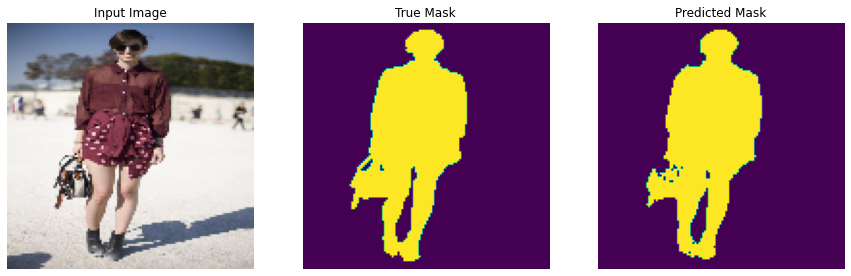


Sample Prediction after epoch 7

201/201 [==============================] - 14s 70ms/step - loss: 0.0335 - accuracy: 0.9867 - val_loss: 0.0751 - val_accuracy: 0.9742
Epoch 8/20
201/201 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9884

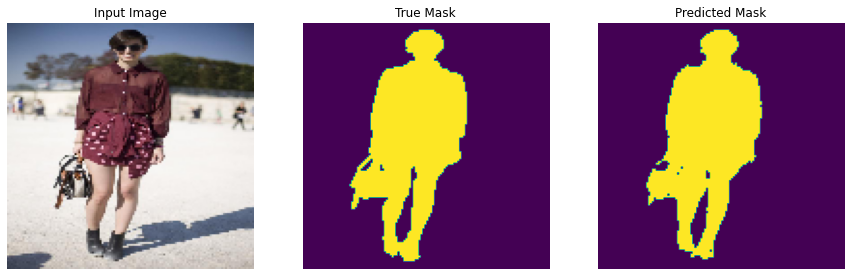


Sample Prediction after epoch 8

201/201 [==============================] - 13s 67ms/step - loss: 0.0292 - accuracy: 0.9884 - val_loss: 0.0780 - val_accuracy: 0.9743
Epoch 9/20
201/201 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9895

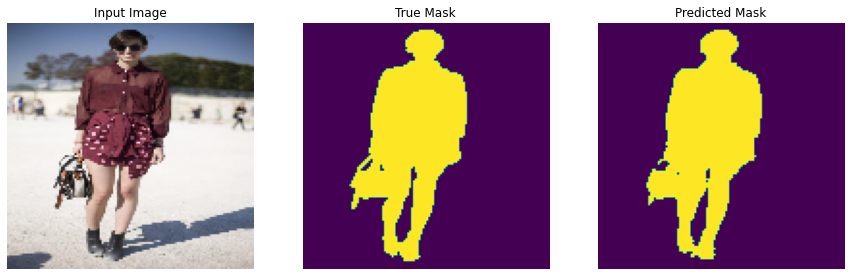


Sample Prediction after epoch 9

201/201 [==============================] - 14s 68ms/step - loss: 0.0265 - accuracy: 0.9895 - val_loss: 0.0786 - val_accuracy: 0.9745
Epoch 10/20
201/201 [==============================] - ETA: 0s - loss: 0.0246 - accuracy: 0.9902

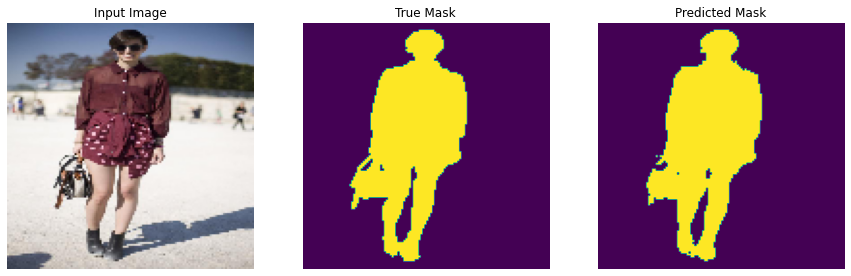


Sample Prediction after epoch 10

201/201 [==============================] - 13s 66ms/step - loss: 0.0246 - accuracy: 0.9902 - val_loss: 0.0824 - val_accuracy: 0.9746
Epoch 11/20
201/201 [==============================] - ETA: 0s - loss: 0.0223 - accuracy: 0.9911

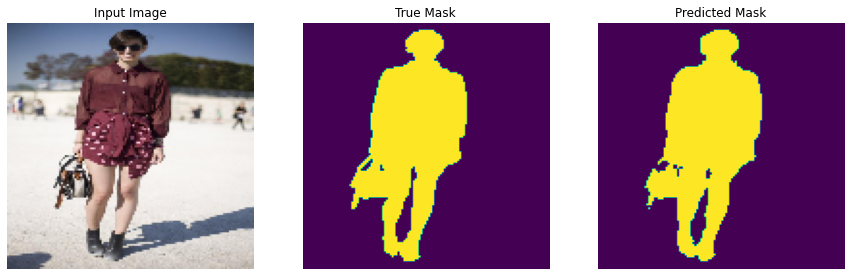


Sample Prediction after epoch 11

201/201 [==============================] - 13s 65ms/step - loss: 0.0223 - accuracy: 0.9911 - val_loss: 0.0856 - val_accuracy: 0.9744
Epoch 12/20
201/201 [==============================] - ETA: 0s - loss: 0.0203 - accuracy: 0.9919

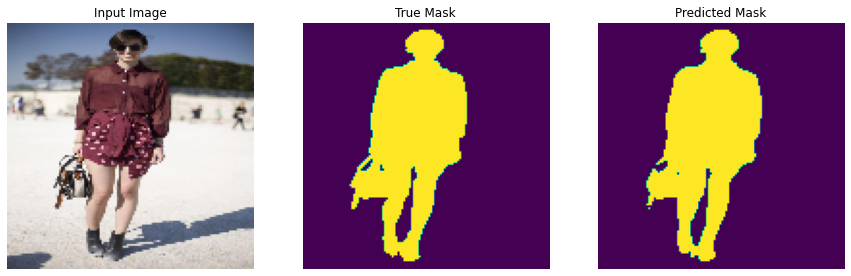


Sample Prediction after epoch 12

201/201 [==============================] - 13s 64ms/step - loss: 0.0203 - accuracy: 0.9919 - val_loss: 0.0885 - val_accuracy: 0.9745
Epoch 13/20
201/201 [==============================] - ETA: 0s - loss: 0.0194 - accuracy: 0.9923

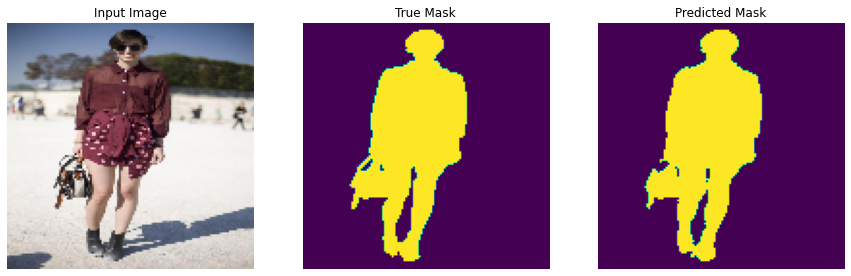


Sample Prediction after epoch 13

201/201 [==============================] - 13s 64ms/step - loss: 0.0194 - accuracy: 0.9923 - val_loss: 0.0936 - val_accuracy: 0.9742
Epoch 14/20
201/201 [==============================] - ETA: 0s - loss: 0.0177 - accuracy: 0.9929

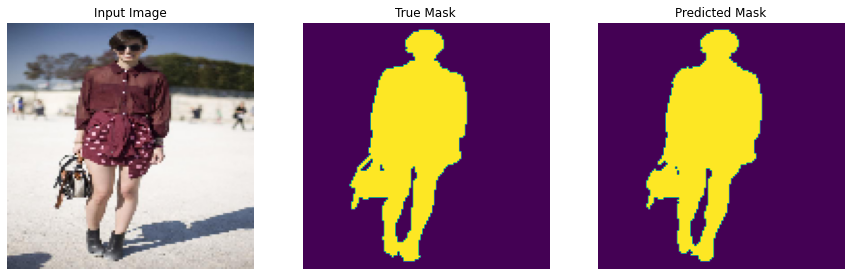


Sample Prediction after epoch 14

201/201 [==============================] - 13s 64ms/step - loss: 0.0177 - accuracy: 0.9929 - val_loss: 0.0974 - val_accuracy: 0.9739
Epoch 15/20
201/201 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9933

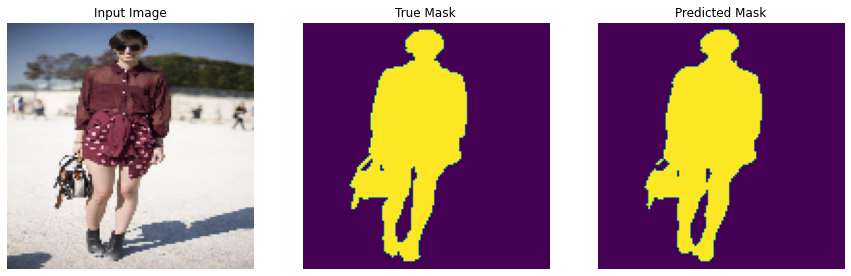


Sample Prediction after epoch 15

201/201 [==============================] - 13s 64ms/step - loss: 0.0169 - accuracy: 0.9933 - val_loss: 0.0983 - val_accuracy: 0.9744
Epoch 16/20
201/201 [==============================] - ETA: 0s - loss: 0.0159 - accuracy: 0.9937

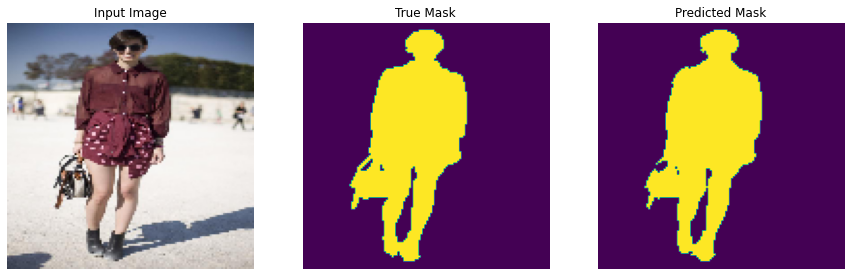


Sample Prediction after epoch 16

201/201 [==============================] - 13s 64ms/step - loss: 0.0159 - accuracy: 0.9937 - val_loss: 0.1032 - val_accuracy: 0.9741
Epoch 17/20
201/201 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9942

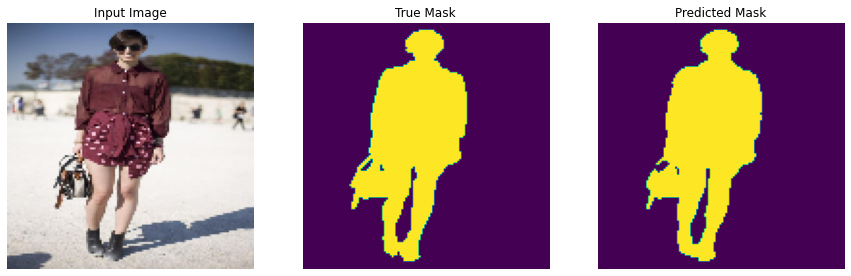


Sample Prediction after epoch 17

201/201 [==============================] - 13s 64ms/step - loss: 0.0148 - accuracy: 0.9942 - val_loss: 0.1042 - val_accuracy: 0.9740
Epoch 18/20
201/201 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9941

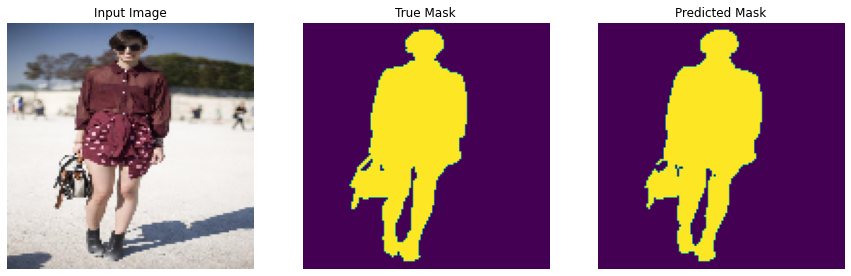


Sample Prediction after epoch 18

201/201 [==============================] - 13s 64ms/step - loss: 0.0147 - accuracy: 0.9941 - val_loss: 0.1012 - val_accuracy: 0.9741
Epoch 19/20
201/201 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9942

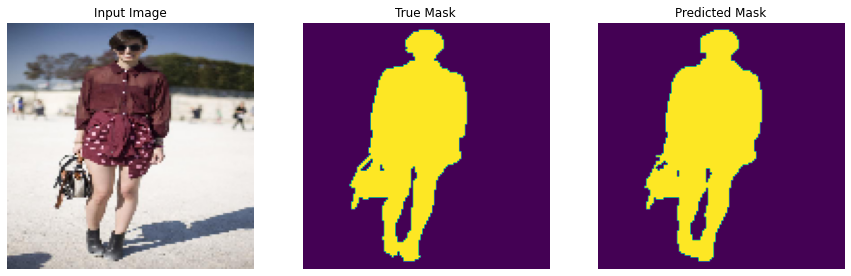


Sample Prediction after epoch 19

201/201 [==============================] - 13s 64ms/step - loss: 0.0147 - accuracy: 0.9942 - val_loss: 0.1090 - val_accuracy: 0.9737
Epoch 20/20
201/201 [==============================] - ETA: 0s - loss: 0.0121 - accuracy: 0.9953

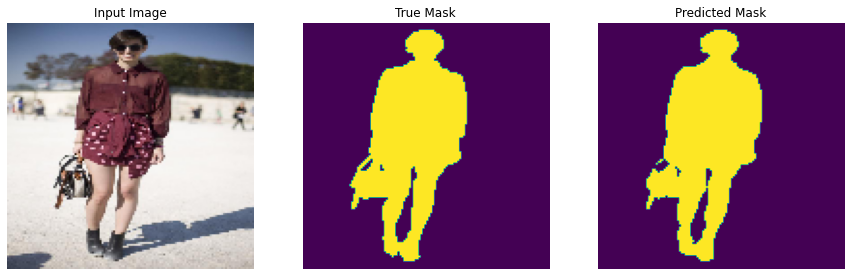


Sample Prediction after epoch 20

201/201 [==============================] - 13s 64ms/step - loss: 0.0121 - accuracy: 0.9953 - val_loss: 0.1152 - val_accuracy: 0.9738


In [21]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    show_predictions(model)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))


EPOCHS = 20

model_history = model.fit(train, epochs=EPOCHS,
                          batch_size=BATCH_SIZE,
                          validation_data=test,
                          callbacks=[DisplayCallback()])
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

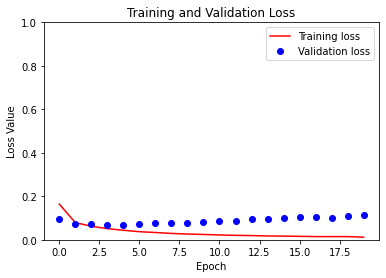

In [22]:
epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

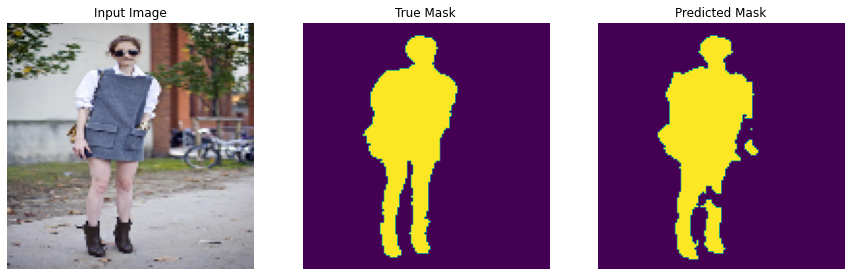

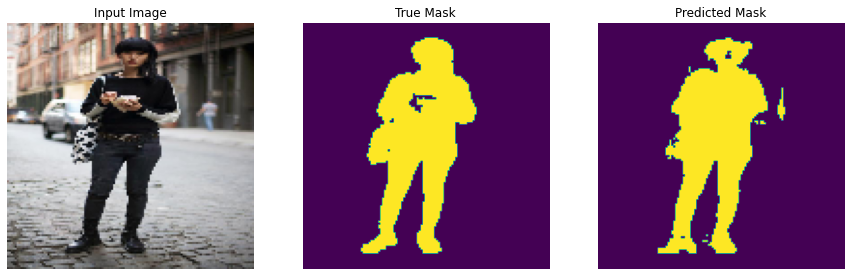

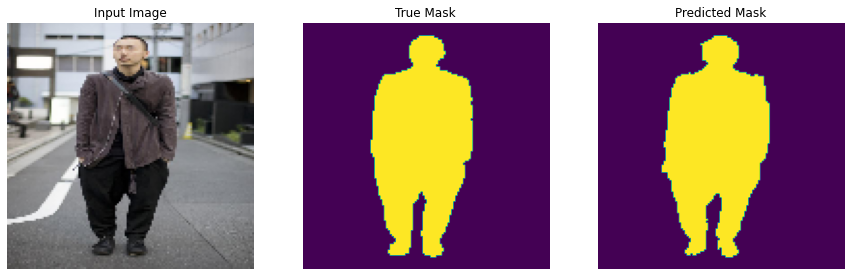

In [23]:
show_predictions(model, test, 3)

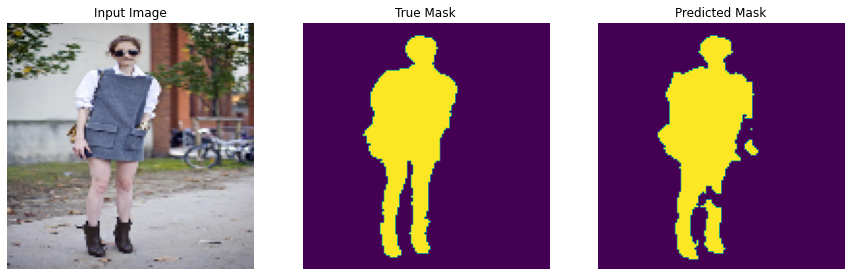

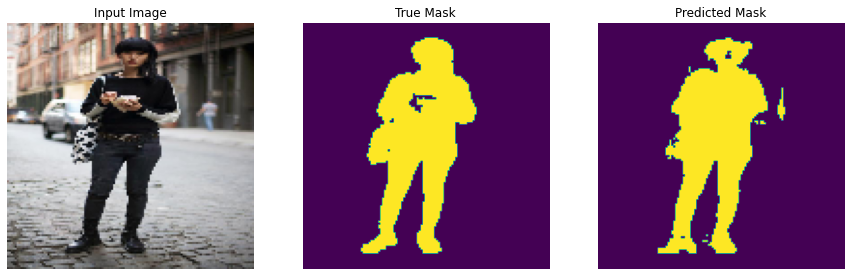

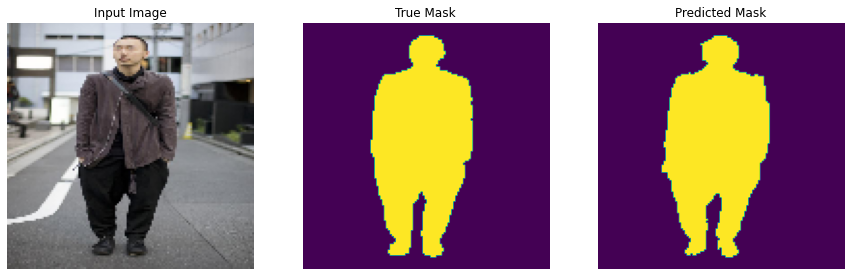

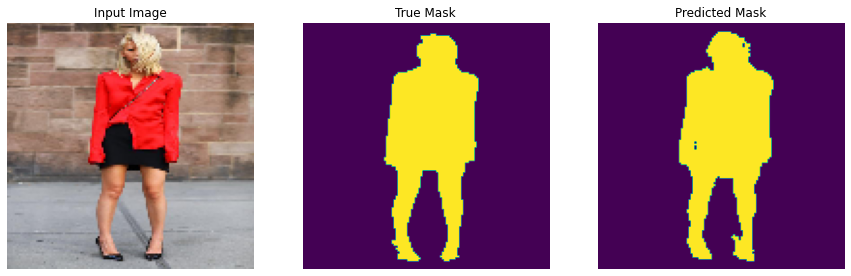

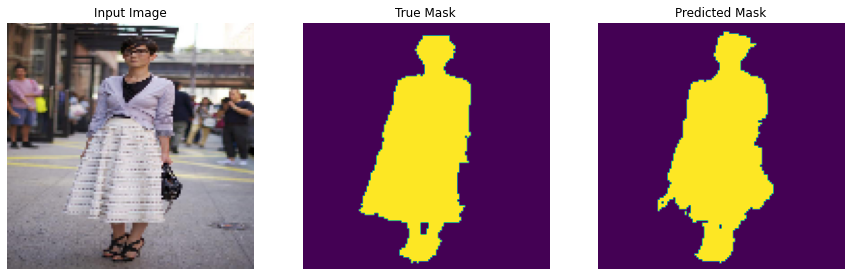

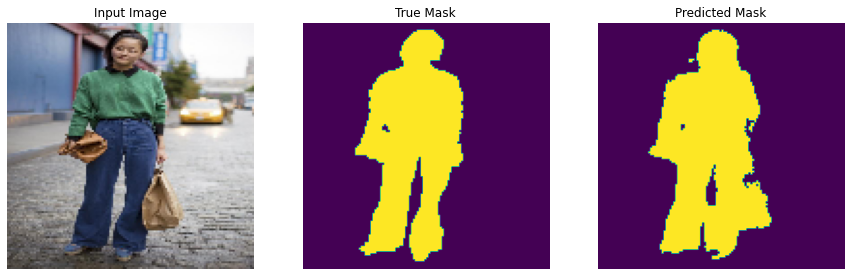

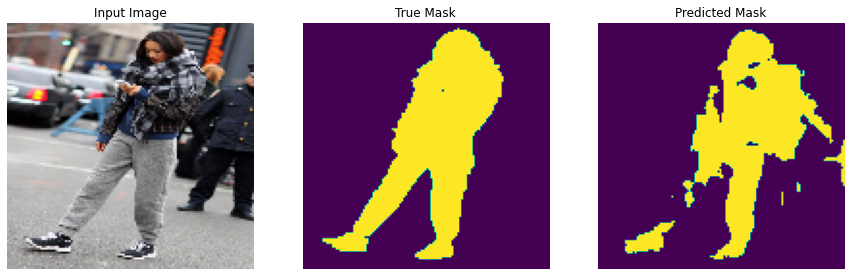

In [24]:
show_predictions(model, test, 30)